Single run stats: {'steps_taken': 50, 'percent_clean': 90.5, 'total_moves': 48, 'finished_early': False, 'width': 20, 'height': 20, 'n_agents': 1, 'dirty_pct_init': 10.0, 'max_steps': 50}

Raw trial results (head):
   agents  trial  steps_taken  percent_clean  total_moves  finished_early
0       1      1         2000          96.75         1873           False
1       1      2         2000          97.00         1872           False
2       1      3         2000          95.50         1878           False
3       1      4         2000          95.00         1880           False
4       1      5         2000          89.50         1902           False

Summary by #agents:
   agents  steps_mean  steps_std  moves_mean  moves_std  pct_clean_mean  \
0       1     2000.00       0.00     1877.75      11.60           95.56   
1       3     1823.38     259.74     5331.00     779.89           99.78   
2       5     1192.50     332.78     5822.50    1663.92          100.00   
3       8      779.5

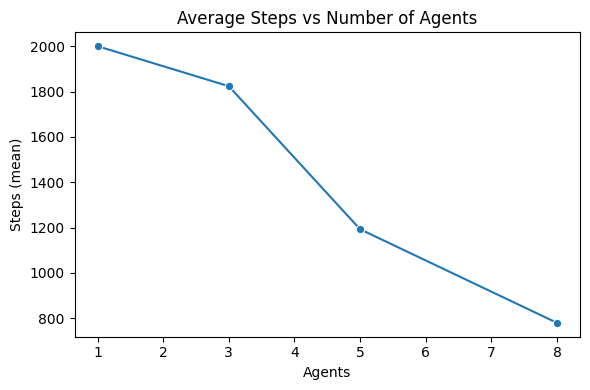

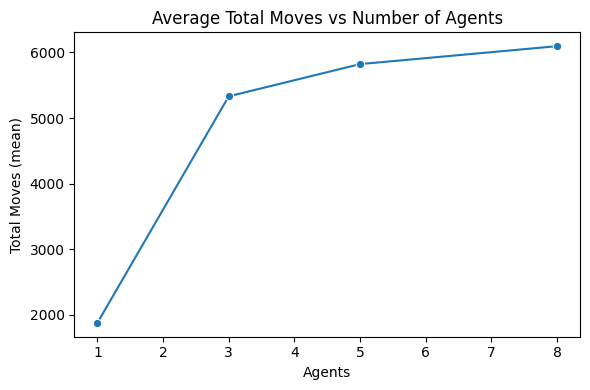

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from typing import List, Tuple, Optional, Dict


# Cleaner Agent
class CleanerAgent(CellAgent):
    
    # Simple reactive agent:
    # - If this cell is dirty, clean it and stop.
    # - Otherwise, try moving to a random neighbor (8 directions).
    # - If no move is possible, stay put.

    def __init__(self, model: "CleaningModel", cell):
        super().__init__(model)
        self.cell = cell          # where the agent is right now (Cell)
        self.moves = 0            # how many times this agent has moved

    def step(self):
        # If we're on dirt, clean it and we're done for this tick.
        if self.model.is_cell_dirty(self.cell.coordinate):
            self.model.clean_cell(self.cell.coordinate)
            return

        # Otherwise pick a random neighbor and go there if it's valid.
        nbr = self.cell.neighborhood.select_random_cell()
        if nbr is not None and nbr is not self.cell:
            self.cell = nbr
            self.moves += 1
        # If there's no neighbor (edge cases), we just don't move.


# Cleaning Model
class CleaningModel(mesa.Model):
    
    # Grid of size width x height with dirty/clean cells.
    # All agents start at (0,0) which is [1,1] in 1-based terms.
    # Each global step: we shuffle agents and each one acts once.
    # We stop when everything is clean or we hit max_steps.

    def __init__(
        self,
        width: int,
        height: int,
        n_agents: int,
        dirty_pct: float,      # e.g. 0.3 means 30% of cells start dirty
        max_steps: int,
        seed: Optional[int] = None,
        torus: bool = False,   # False = walls; if you can't move outside, you stay
        capacity: int = 100,   # how many agents a cell can hold
    ):
        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.n_agents = n_agents
        self.dirty_pct = float(dirty_pct)
        self.max_steps = max_steps

        # 8-neighbor grid (Moore). Not wrapping around by default.
        self.grid = OrthogonalMooreGrid(
            (self.width, self.height),
            torus=torus,
            capacity=capacity,
            random=self.random,
        )

        # Quick lookup: (x, y) -> Cell
        self._cell_by_coord = {c.coordinate: c for c in self.grid.all_cells}

        # True = dirty, False = clean
        self._dirty = np.zeros((self.width, self.height), dtype=bool)

        # Pick which cells start dirty based on the percentage.
        self._init_dirty_cells()

        # Drop everyone at (0,0). That's [1,1] in 1-based indexing.
        start_cell = self._cell_by_coord[(0, 0)]
        self.agents_list: List[CleanerAgent] = CleanerAgent.create_agents(
            self,
            self.n_agents,
            [start_cell] * self.n_agents,
        )

        # Bookkeeping
        self.current_step = 0
        self.finished_early = False  # True if we cleaned everything before max_steps

    # Dirty helpers
    def _init_dirty_cells(self):
        total = self.width * self.height
        k = int(round(self.dirty_pct * total))
        all_coords = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_coords)
        for (x, y) in all_coords[:k]:
            self._dirty[x, y] = True

    def is_cell_dirty(self, coord: Tuple[int, int]) -> bool:
        x, y = coord
        return self._dirty[x, y]

    def clean_cell(self, coord: Tuple[int, int]) -> None:
        x, y = coord
        self._dirty[x, y] = False

    def n_dirty(self) -> int:
        return int(self._dirty.sum())

    def percent_clean(self) -> float:
        total = self.width * self.height
        clean = total - self.n_dirty()
        return clean / total if total > 0 else 1.0

    def total_agent_moves(self) -> int:
        return int(sum(a.moves for a in self.agents_list))

    # One global tick
    def step(self):
        # If we're already clean, mark it and stop ticking.
        if self.n_dirty() == 0:
            self.finished_early = True
            return

        # Let each agent act once in random order.
        self.agents.shuffle_do("step")
        self.current_step += 1

    def run_until_done(self):
        
        # Keep stepping until either:
        # - all cells are clean, or
        # - we hit max_steps.
        # Then return a dict with the stats we care about.
        
        while self.current_step < self.max_steps and self.n_dirty() > 0:
            self.step()

        if self.n_dirty() == 0:
            self.finished_early = True

        return {
            "steps_taken": self.current_step,
            "percent_clean": round(self.percent_clean() * 100.0, 2),
            "total_moves": self.total_agent_moves(),
            "finished_early": self.finished_early,
            "width": self.width,
            "height": self.height,
            "n_agents": self.n_agents,
            "dirty_pct_init": round(self.dirty_pct * 100.0, 2),
            "max_steps": self.max_steps,
        }

    # Optional helpers for visuals
    def agent_count_grid(self) -> np.ndarray:
        # How many agents sit on each cell right now.
        counts = np.zeros((self.width, self.height), dtype=int)
        for cell in self.grid.all_cells:
            counts[cell.coordinate] = len(cell.agents)
        return counts

    def dirty_grid(self) -> np.ndarray:
        # Copy of the dirty/clean matrix (True = dirty).
        return self._dirty.copy()


# Experiment helpers
def run_single(
    width: int,
    height: int,
    n_agents: int,
    dirty_pct: float,
    max_steps: int,
    seed: Optional[int] = None,
) -> Dict:
    model = CleaningModel(
        width=width,
        height=height,
        n_agents=n_agents,
        dirty_pct=dirty_pct,
        max_steps=max_steps,
        seed=seed,
        torus=False,
    )
    return model.run_until_done()


def run_experiments(
    width: int,
    height: int,
    agent_grid: List[int],
    dirty_pct: float,
    max_steps: int,
    trials_per_config: int = 5,
    base_seed: int = 123,
) -> pd.DataFrame:
    
    # Try multiple agent counts and repeat each a few times.
    # Returns a tidy DataFrame with one row per trial.
    
    rows = []
    for i, n_agents in enumerate(agent_grid):
        for t in range(trials_per_config):
            seed = base_seed + i * 10_000 + t
            stats = run_single(
                width=width,
                height=height,
                n_agents=n_agents,
                dirty_pct=dirty_pct,
                max_steps=max_steps,
                seed=seed,
            )
            rows.append(
                {
                    "agents": n_agents,
                    "trial": t + 1,
                    "steps_taken": stats["steps_taken"],
                    "percent_clean": stats["percent_clean"],
                    "total_moves": stats["total_moves"],
                    "finished_early": stats["finished_early"],
                }
            )
    return pd.DataFrame(rows)


def summarize_results(df: pd.DataFrame) -> pd.DataFrame:
    
    # Group by #agents and compute mean/std for each metric.
    
    grp = df.groupby("agents", as_index=False).agg(
        steps_mean=("steps_taken", "mean"),
        steps_std=("steps_taken", "std"),
        moves_mean=("total_moves", "mean"),
        moves_std=("total_moves", "std"),
        pct_clean_mean=("percent_clean", "mean"),
        pct_clean_std=("percent_clean", "std"),
        finished_rate=("finished_early", "mean"),
    )
    # Round numbers
    for c in grp.columns:
        if c.endswith(("_mean", "_std", "finished_rate")):
            grp[c] = grp[c].round(2)
    return grp


def quick_plots(df_summary: pd.DataFrame):
    
    # Two small plots for the report.
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df_summary, x="agents", y="steps_mean", marker="o", ax=ax)
    ax.set_title("Average Steps vs Number of Agents")
    ax.set_xlabel("Agents")
    ax.set_ylabel("Steps (mean)")
    plt.tight_layout()

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df_summary, x="agents", y="moves_mean", marker="o", ax=ax2)
    ax2.set_title("Average Total Moves vs Number of Agents")
    ax2.set_xlabel("Agents")
    ax2.set_ylabel("Total Moves (mean)")
    plt.tight_layout()


if __name__ == "__main__":
    model_stats = run_single(
        width=20,
        height=20,
        n_agents=1,
        dirty_pct=0.10,   
        max_steps=50,
        seed=42,
    )
    print("Single run stats:", model_stats)

    # experiment for the report
    df = run_experiments(
        width=20,
        height=20,
        agent_grid=[1, 3, 5, 8],
        dirty_pct=0.35,
        max_steps=3000,
        trials_per_config=8,
        base_seed=2025,
    )
    print("\nRaw trial results (head):")
    print(df.head())

    summary = summarize_results(df)
    print("\nSummary by #agents:")
    print(summary)

    quick_plots(summary)
    plt.show()
